@article{diode_dataset,
  title={{DIODE}: {A} {D}ense {I}ndoor and {O}utdoor {DE}pth {D}ataset},
  author={Igor Vasiljevic and Nick Kolkin and Shanyi Zhang and Ruotian Luo and
  Haochen Wang and Falcon Z. Dai and Andrea F. Daniele and Mohammadreza Mostajabi and
  Steven Basart and Matthew R. Walter and Gregory Shakhnarovich},
  journal={CoRR},
  volume={abs/1908.00463},
  year={2019},
  url={http ://arxiv.org/abs/1908.00463}
}

In [1]:
import os
import sys

import tensorflow as tf
from tensorflow.keras import layers

import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

tf.random.set_seed(24)

In [2]:
annotation_folder = "/data/"
if not os.path.exists(os.path.abspath(".") + annotation_folder):
    annotation_zip = tf.keras.utils.get_file(
        "val.tar.gz",
        cache_subdir=os.path.abspath("."),
        origin="http://diode-dataset.s3.amazonaws.com/val.tar.gz",
        extract=True,
    )

2774625282/2774625282 [==============================] - 84s 0us/step


In [3]:
path = '/content/val/outdoor'

In [4]:
paths = []
for root, dirs, files in os.walk(path):
    for file in files:
        paths.append(os.path.join(root, file))

In [5]:
paths = np.sort(paths)

In [6]:
len(paths)

1338

In [7]:
def enhance_depth_map1(depth_map , mask):
  depth_map = np.load(depth_map).squeeze()
  mask = np.load(mask)
  mask = mask > 0
  max_depth = min(300, np.percentile(depth_map, 99))
  depth_map = np.clip(depth_map, 0.1, max_depth)
  depth_map = np.log(depth_map, where=mask)
  depth_map = np.ma.masked_where(~mask, depth_map)
  depth_map = np.clip(depth_map, 0.1, np.log(max_depth))
  depth_map = cv2.resize(depth_map, (512, 512))
  depth_map = np.expand_dims(depth_map, axis=2)
  depth_map = tf.image.convert_image_dtype(depth_map, tf.float32)
  return depth_map

In [8]:
from skimage import exposure

def enhance_depth_map2(depth_map_path, mask_path):
    # Load depth map and mask data
    depth_map = np.load(depth_map_path).squeeze()
    mask = np.load(mask_path)
    mask = mask > 0
    max_depth = min(300, np.percentile(depth_map, 99))
    depth_map = np.clip(depth_map, 0.1, max_depth)
    enhanced_depth_map = exposure.equalize_hist(depth_map, mask=mask)
    resized_depth_map = cv2.resize(enhanced_depth_map, (512, 512))
    expanded_depth_map = np.expand_dims(resized_depth_map, axis=2)
    converted_depth_map = tf.image.convert_image_dtype(expanded_depth_map, tf.float32)
    return converted_depth_map


In [9]:
def multi_scale_retinex(img, sigma_list, G, b, alpha, low_clip, high_clip):
    img = np.float64(img) + 1.0

    retinex = np.zeros_like(img)
    for sigma in sigma_list:
        gaussian = cv2.GaussianBlur(img, (G, G), sigma)
        retinex = retinex + np.log10(img) - np.log10(gaussian)

    retinex = alpha * retinex

    retinex = np.where(retinex < low_clip, low_clip, retinex)
    retinex = np.where(retinex > high_clip, high_clip, retinex)

    retinex = (retinex - np.min(retinex)) / (np.max(retinex) - np.min(retinex)) * 255
    retinex = np.uint8(retinex)

    return retinex

def enhance_depth_map_retinex(depth_map_path, mask_path, target_size=(512, 512), sigma_list=(15, 80, 250), G=15, b=25, alpha=125, low_clip=0, high_clip=255):
    depth_map = np.load(depth_map_path).squeeze()
    mask = np.load(mask_path)
    mask = mask > 0
    enhanced_depth_map = multi_scale_retinex(depth_map, sigma_list, G, b, alpha, low_clip, high_clip)
    resized_depth_map = cv2.resize(enhanced_depth_map, target_size)
    expanded_depth_map = np.expand_dims(resized_depth_map, axis=2)
    converted_depth_map = tf.image.convert_image_dtype(expanded_depth_map, tf.float32)

    return converted_depth_map


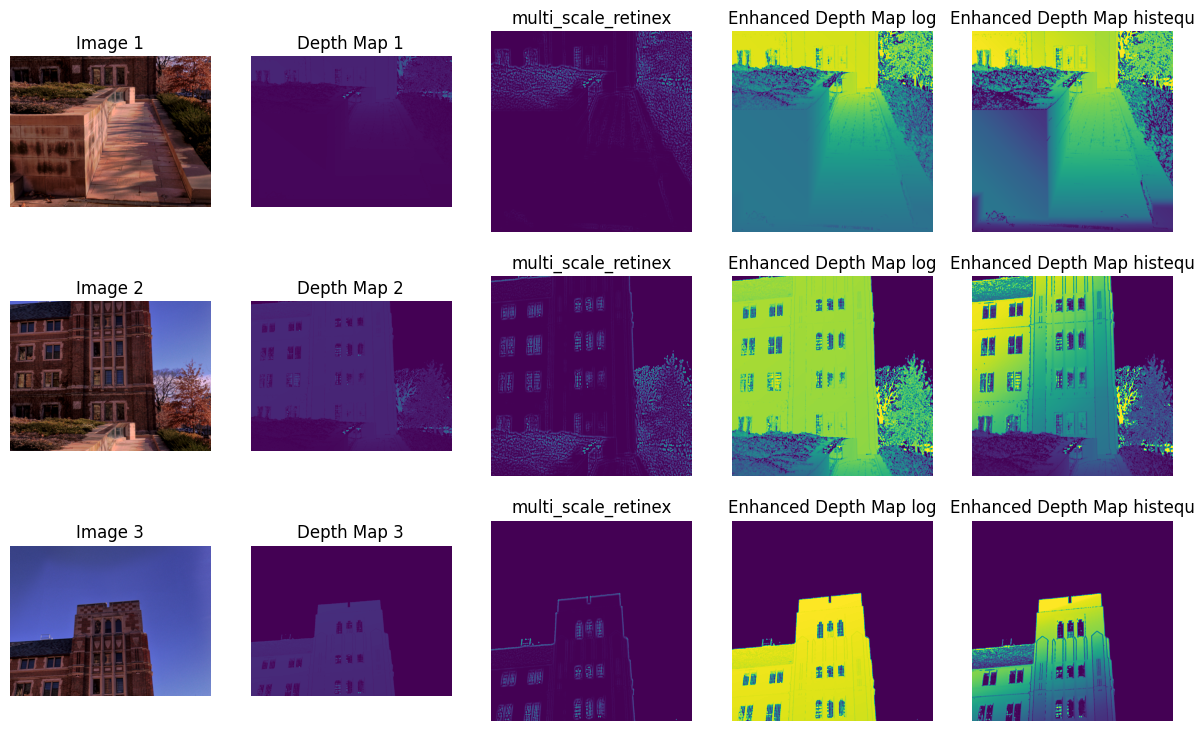

In [10]:
image_paths = [paths[i] for i in range(0 , 8 , 3)]  # Example image paths
depth_arrays = [np.load(paths[i+1]) for i in range(0 , 8 , 3)]
depth_mask_arrays = [np.load(paths[i+2]) for i in range(0 , 8 , 3)]
depth1 = [enhance_depth_map1(paths[i+1] , paths[i+2]) for i in range(0 , 8 , 3)]
depth2 = [enhance_depth_map2(paths[i+1] , paths[i+2]) for i in range(0 , 8 , 3)]
depth3 = [enhance_depth_map_retinex(paths[i+1] , paths[i+2]) for i in range(0 , 8 , 3)]

fig, axes = plt.subplots(len(image_paths), 5, figsize=(15, 3*len(image_paths)))
fig.subplots_adjust(wspace=0.2)

for i in range(len(image_paths)):
    image = plt.imread(image_paths[i])

    axes[i, 0].imshow(image)
    axes[i, 0].set_title('Image {}'.format(i + 1))
    axes[i, 0].axis('off')

    axes[i, 1].imshow(depth_arrays[i], cmap='viridis')
    axes[i, 1].set_title('Depth Map {}'.format(i + 1))
    axes[i, 1].axis('off')

    axes[i, 2].imshow(depth3[i], cmap='viridis')
    axes[i, 2].set_title('multi_scale_retinex')
    axes[i, 2].axis('off')

    axes[i, 3].imshow(depth1[i], cmap='viridis')
    axes[i, 3].set_title('Enhanced Depth Map log')
    axes[i, 3].axis('off')

    axes[i, 4].imshow(depth2[i], cmap='viridis')
    axes[i, 4].set_title('Enhanced Depth Map histequ')
    axes[i, 4].axis('off')



plt.show()


so the hist Histogram Equalization is choosed

In [11]:
files = []
depth_files = []
mask_files = []
for i in range(0 , len(paths)-2 , 3):
  files.append(paths[i])
  depth_files.append(paths[i+1])
  mask_files.append(paths[i+2])

In [12]:
len(files) , len(depth_files) , len(mask_files)

(446, 446, 446)

In [13]:
np.load(mask_files[0]).shape

(768, 1024)

In [14]:
class CustomDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, list_images, list_depth_maps, list_masks, batch_size=5, dim=(512, 512), n_channels=1, shuffle=True):
        """
        Initialization
        """
        self.list_images = list_images
        self.indices = range(len(self.list_images))
        self.list_depth_maps = list_depth_maps
        self.list_masks = list_masks
        self.batch_size = batch_size
        self.n_channels = n_channels
        self.dim = dim
        self.shuffle = shuffle
        self.min_depth = 0.1
        self.on_epoch_end()


    def __len__(self):
        return int(np.ceil(len(self.list_images) / float(self.batch_size)))

    def __getitem__(self, index):
        if (index + 1) * self.batch_size > len(self.indices):
            self.batch_size = len(self.indices) - index * self.batch_size
        index = self.indices[index * self.batch_size : (index + 1) * self.batch_size]
        batch = [self.indices[k] for k in index]
        x, y = self.data_generation(batch)

        return x, y

    def on_epoch_end(self):

        """
        Updates indexes after each epoch
        """
        self.index = np.arange(len(self.indices))
        if self.shuffle == True:
            np.random.shuffle(self.index)

    def load(self, image_path, depth_path, mask):
        """Load input and target image."""

        image_ = cv2.imread(image_path)
        image_ = cv2.cvtColor(image_, cv2.COLOR_BGR2RGB)
        image_ = cv2.resize(image_, self.dim)
        image_ = tf.image.convert_image_dtype(image_, tf.float32)

        depth_map = enhance_depth_map2(depth_path , mask)

        return image_, depth_map

    def data_generation(self, batch):

        x = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, *self.dim, 1))

        for i, batch_id in enumerate(batch):
            x[i,], y[i,] = self.load(
                self.list_images[batch_id],
                self.list_depth_maps[batch_id],
                self.list_masks[batch_id],
            )

        return x, y

In [24]:
from sklearn.model_selection import train_test_split
train_images, val_images, train_labels, val_labels = train_test_split(files, depth_files, test_size=0.2, random_state=42)


In [70]:
data_generator = CustomDataGenerator(train_images , train_labels , mask_files, batch_size=3 ,dim=(512, 512), n_channels=3, shuffle=True)
val_generator = CustomDataGenerator(val_images , val_labels , mask_files, batch_size=5 ,dim=(512, 512), n_channels=3, shuffle=True)

# Access batches using data_generator[i]
# Example:
batch_images, batch_depth_maps =  val_generator.__getitem__(0)

In [71]:
depth_maps = batch_depth_maps[0]

# Calculate basic statistics
min_depth = np.min(depth_maps)
max_depth = np.max(depth_maps)
mean_depth = np.mean(depth_maps)
std_depth = np.std(depth_maps)

print(f"Minimum Depth: {min_depth}")
print(f"Maximum Depth: {max_depth}")
print(f"Mean Depth: {mean_depth}")
print(f"Standard Deviation of Depth: {std_depth}")

Minimum Depth: 0.48547255992889404
Maximum Depth: 1.0
Mean Depth: 0.6179162743857205
Standard Deviation of Depth: 0.1604353702360011


In [64]:
batch_images.shape , batch_depth_maps.shape

((5, 512, 512, 3), (5, 512, 512, 1))

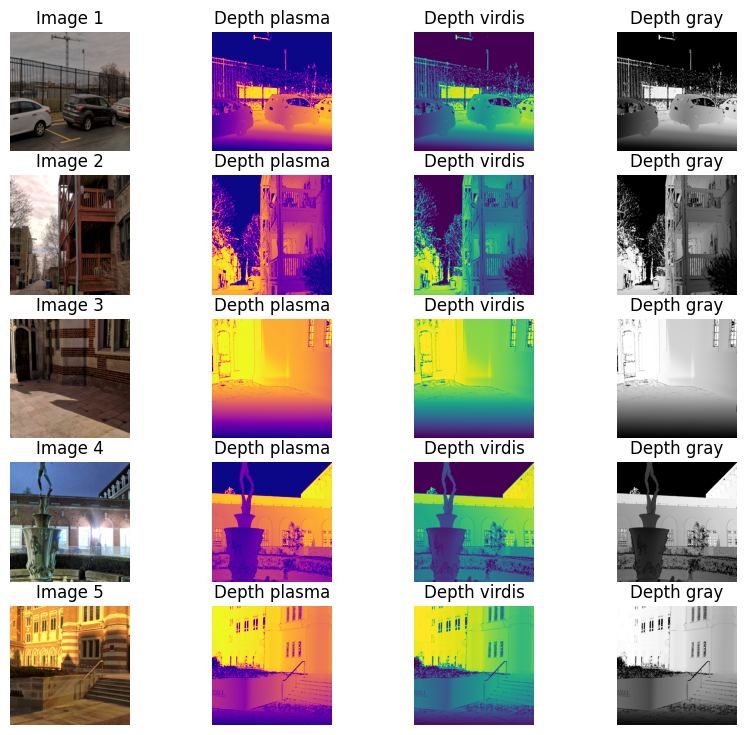

In [72]:
image_to_visualize = batch_images[:5]
depth_map_to_visualize = batch_depth_maps[:5]

fig, axes = plt.subplots(5, 4, figsize=(10, 3*len(image_paths)))
fig.subplots_adjust(wspace=0.2)

for i in range(5):
    axes[i, 0].imshow(batch_images[i] , cmap='jet')
    axes[i, 0].set_title('Image {}'.format(i + 1))
    axes[i, 0].axis('off')

    axes[i, 1].imshow(batch_depth_maps[i] , cmap='plasma')
    axes[i, 1].set_title('Depth plasma')
    axes[i, 1].axis('off')

    axes[i, 2].imshow(batch_depth_maps[i] , cmap='viridis')
    axes[i, 2].set_title('Depth virdis')
    axes[i, 2].axis('off')

    axes[i, 3].imshow(batch_depth_maps[i] , cmap='gray')
    axes[i, 3].set_title('Depth gray')
    axes[i, 3].axis('off')


# in progress...

---



---

---



---





---



# The model

In [74]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_depth_estimation_model(input_shape=(512, 512, 3)):
    # Encoder
    inputs = tf.keras.Input(shape=input_shape)
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bottom layer
    conv4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)

    # Decoder
    up5 = layers.UpSampling2D(size=(2, 2))(conv4)
    concat5 = layers.Concatenate()([up5, conv3])
    conv5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(concat5)
    conv5 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv5)

    up6 = layers.UpSampling2D(size=(2, 2))(conv5)
    concat6 = layers.Concatenate()([up6, conv2])
    conv6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(concat6)
    conv6 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv6)

    up7 = layers.UpSampling2D(size=(2, 2))(conv6)
    concat7 = layers.Concatenate()([up7, conv1])
    conv7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(concat7)
    conv7 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv7)

    # Output layer with sigmoid activation for normalized depth values
    outputs = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(conv7)

    # Create the model
    model = models.Model(inputs=inputs, outputs=outputs)

    # Compile the model with Mean Squared Error (MSE) loss
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error', 'mean_squared_error'])

    return model

# Build the depth estimation model
depth_estimation_model = build_depth_estimation_model(input_shape=(512, 512, 3))

# Print model summary
depth_estimation_model.summary()


Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_16 (InputLayer)       [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d_115 (Conv2D)         (None, 512, 512, 64)         1792      ['input_16[0][0]']            
                                                                                                  
 conv2d_116 (Conv2D)         (None, 512, 512, 64)         36928     ['conv2d_115[0][0]']          
                                                                                                  
 max_pooling2d_17 (MaxPooli  (None, 256, 256, 64)         0         ['conv2d_116[0][0]']          
 ng2D)                                                                                      

In [19]:
# import tensorflow as tf
# from tensorflow.keras.utils import get_custom_objects
# from tensorflow.image import ssim
# import tensorflow.keras.backend as K

# # Define the custom loss function that combines SSIM and Huber loss
# def custom_loss(y_true, y_pred):
#     alpha = 0.85  # Weight for the SSIM loss
#     beta = 0.15   # Weight for the Huber loss

#     # Compute the SSIM loss
#     ssim_loss = 1 - ssim(y_true, y_pred, max_val=1.0)

#     # Compute the Huber loss
#     huber_loss = tf.keras.losses.Huber()(y_true, y_pred)

#     # Combine the SSIM and Huber loss
#     total_loss = alpha * ssim_loss + beta * huber_loss
#     return total_loss

# # Register the custom loss function with get_custom_objects
# get_custom_objects().update({'custom_loss': custom_loss})

# # Compile the model with the custom loss function
# model.compile(loss=custom_loss, optimizer='adam')


In [59]:
# monodepth2_model.compile(optimizer='adam', loss='mean_squared_error' , metrics = 'mean_absolute_error')

# Train the model with the preprocessed data
# Example: transfer_learning_model.fit(train_images_preprocessed, train_depth_maps, epochs=num_epochs, validation_data=(val_images_preprocessed, val_depth_maps))


In [75]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=3, min_lr=0.000001, verbose=1)

depth_estimation_model.fit(data_generator, epochs=100, steps_per_epoch=20,validation_data = val_generator , callbacks=[reduce_lr])


Epoch 1/100
20/20 [==============================] - 50s 1s/step - loss: 0.0846 - mean_absolute_error: 0.2466 - mean_squared_error: 0.0846 - val_loss: 0.0707 - val_mean_absolute_error: 0.2254 - val_mean_squared_error: 0.0707 - lr: 0.0010
Epoch 2/100
20/20 [==============================] - 27s 1s/step - loss: 0.0750 - mean_absolute_error: 0.2374 - mean_squared_error: 0.0750 - val_loss: 0.0690 - val_mean_absolute_error: 0.2230 - val_mean_squared_error: 0.0690 - lr: 0.0010
Epoch 3/100
20/20 [==============================] - 27s 1s/step - loss: 0.0789 - mean_absolute_error: 0.2439 - mean_squared_error: 0.0789 - val_loss: 0.0688 - val_mean_absolute_error: 0.2228 - val_mean_squared_error: 0.0688 - lr: 0.0010
Epoch 4/100
20/20 [==============================] - 27s 1s/step - loss: 0.0697 - mean_absolute_error: 0.2255 - mean_squared_error: 0.0697 - val_loss: 0.0685 - val_mean_absolute_error: 0.2223 - val_mean_squared_error: 0.0685 - lr: 0.0010
Epoch 5/100
20/20 [=============================

In [76]:
image_to_visualize = batch_images[:5]
depth_map_to_visualize = batch_depth_maps[:5]

In [78]:
y = depth_estimation_model.predict(image_to_visualize)

1/1 [==============================] - 0s 264ms/step


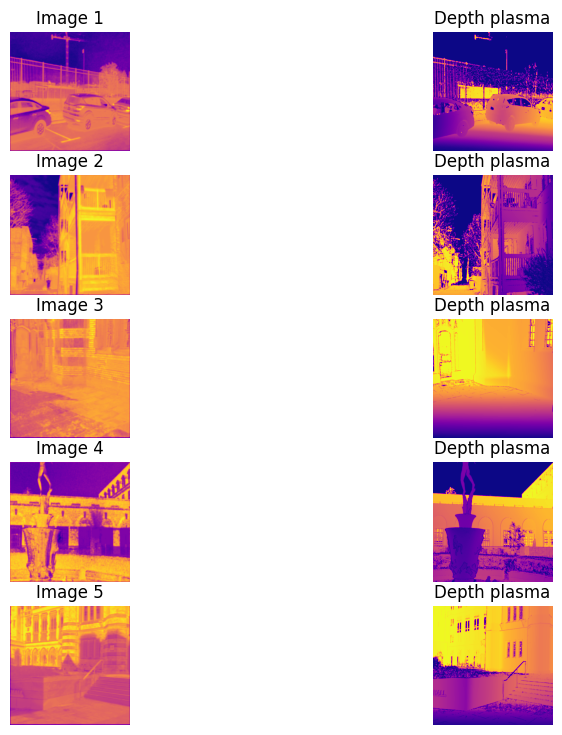

In [79]:
depth_map_to_visualize = batch_depth_maps[:5]

fig, axes = plt.subplots(5, 2, figsize=(10, 3*len(image_paths)))
fig.subplots_adjust(wspace=0.2)

for i in range(5):
    axes[i, 0].imshow(y[i] , cmap='plasma')
    axes[i, 0].set_title('Image {}'.format(i + 1))
    axes[i, 0].axis('off')

    axes[i, 1].imshow(batch_depth_maps[i] , cmap='plasma')
    axes[i, 1].set_title('Depth plasma')
    axes[i, 1].axis('off')

